In [147]:
import numpy as np
import pandas as pd

import os
import glob

import matplotlib.pyplot as plt

In [149]:
num_samples = 50
num_classes = 1000
num_images = num_samples * num_classes
class_inds = np.zeros((num_classes, 2))
for j, i in enumerate(range(0, num_images, num_samples)):
    class_inds[j, :] = [i, i + num_samples]

class ResultSummary():
    name = None
    top1_accuracy = None
    top5_accuracy = None
    classes_top1_accuracy = None
    classes_top5_accuracy = None
    test_index = 0
    test_values = None
    
    def __init__(self, name, num_tests):
        self.name = name
        self.top1_accuracy = np.zeros((1, num_tests))
        self.top5_accuracy = np.zeros((1, num_tests))
        self.classes_top1_accuracy = np.zeros((num_classes, num_tests))
        self.classes_top5_accuracy = np.zeros((num_classes, num_tests))
        self.test_values = np.zeros((1, num_tests))

    def add_test(self, predictions, test_value):
        self.test_values[0, self.test_index] = test_value
        self.top1_accuracy[0, self.test_index] = predictions[:, 0].mean()
        self.top5_accuracy[0, self.test_index] = predictions[:, 1].mean()
        for i in range(num_classes):
            si = int(class_inds[i, 0])
            ei = int(class_inds[i, 1])
            self.classes_top1_accuracy[i, self.test_index] = predictions[si:ei, 0].mean()
            self.classes_top5_accuracy[i, self.test_index] = predictions[si:ei, 1].mean()
        self.test_index += 1

In [205]:
def get_folder_name(folder_path):
    tokens = folder_path.split('/')
    for token in reversed(tokens):
        if token != '':
            return token
    return ''


def get_test_value(test_name):
    tokens = test_name.split('_')
    for token in reversed(tokens):
        if isfloat(token):
            return token


def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

import json
label_file = '/home/arash/Software/repositories/kernelphysiology/data/computervision/ilsvrc/ilsvrc2012/raw-data/ILSVRC2012_validation_labels.json'
with open(label_file) as f:
    imagenet_labels = json.load(f)
imagenet_labels = np.array(imagenet_labels)

all_categories = {}
cat_folder = '/home/arash/Software/repositories/kernelphysiology/data/computervision/ilsvrc/ilsvrc2012/raw-data/categories/'

for cat_file in glob.glob(cat_folder + '/*.txt'):
    cat_name = get_folder_name(cat_file[:-4])
    all_categories[cat_name] = np.loadtxt(cat_file)

In [233]:
def plot_results(networks, original_networks, experiment_name, original_value, cat_inds=None):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 1, 1)
    all_xs = None
    all_ys = []
    for ((key, value), (key_original, value_original)) in zip(networks.items(), original_networks.items()):
        xs = np.concatenate((value.test_values, [[original_value]]), axis=1)
        if cat_inds is None:
            non_original_res = value.top1_accuracy
            original_res = value_original.top1_accuracy
        else:
            non_original_res = value.classes_top1_accuracy[cat_inds.astype('uint'), :].mean(axis=0)
            non_original_res = np.expand_dims(non_original_res, 0)
            original_res = value_original.classes_top1_accuracy[cat_inds.astype('uint'), :].mean(axis=0)
            original_res = np.expand_dims(original_res, 0)
        ys = np.concatenate((non_original_res, original_res), axis=1)
        sorted_inds = np.argsort(xs)
        if all_xs is None:
            all_xs = xs[0, sorted_inds]
        all_ys.append(ys[0, sorted_inds])
        ax.plot(*xs[0, sorted_inds], *ys[0, sorted_inds], marker='o')
    ax.legend(networks.keys(), loc='right', bbox_to_anchor=(1.45, 0.8))
    ax.set_title(experiment_name)
    ax.set_ylim([0, 1])
    all_ys = np.array(all_ys).squeeze()
    ax.axhline(y=all_ys.max(), linestyle='--', color='black')
    plt.show()
    return (all_xs, all_ys)

In [215]:
def do_one_network(result_dir, which_experiments, original_values, which_categories={}, which_networks=None):
    # reading the results for original images
    for experiment_dir in glob.glob(result_dir + '/original/'):
        original_networks = {}

        num_networks = len(glob.glob(experiment_dir + '/*/'))
        for network_dir in sorted(glob.glob(experiment_dir + '/*/')):
            network_name = get_folder_name(network_dir)
            if which_networks is not None and not network_name in which_networks:
                continue
            num_tests = len(glob.glob(network_dir + '/*.csv'))
            original_networks[network_name] = ResultSummary(network_name, 1)
            for prediction_file in sorted(glob.glob(network_dir + '/*.csv')):
                predictions = np.loadtxt(prediction_file, delimiter=',')
                original_networks[network_name].add_test(predictions, 0)

    summary_out = {}
    for w_ind, experiment_name in enumerate(which_experiments):
        networks = {}

        num_networks = len(glob.glob(experiment_dir + '/*/'))
        experiment_dir = result_dir + '/' + experiment_name + '/'
        for network_dir in sorted(glob.glob(experiment_dir + '/*/')):
            network_name = get_folder_name(network_dir)
            if which_networks is not None and not network_name in which_networks:
                continue
            num_tests = len(glob.glob(network_dir + '/*.csv'))
            networks[network_name] = ResultSummary(network_name, num_tests)
            for prediction_file in sorted(glob.glob(network_dir + '/*.csv')):
                predictions = np.loadtxt(prediction_file, delimiter=',')
                test_name = get_folder_name(prediction_file)
                test_value = get_test_value(test_name[:-4])
                networks[network_name].add_test(predictions, test_value)

        (all_xs, all_ys) = plot_results(networks, original_networks, 
                                        experiment_name + '_all', original_values[w_ind])
        for cat_name, cat_val in which_categories.items():
            (_, _) = plot_results(networks, original_networks,
                                  experiment_name + '_' + cat_name, original_values[w_ind],
                                  cat_val)
        summary_out[experiment_name] = (all_xs, all_ys)
    return summary_out

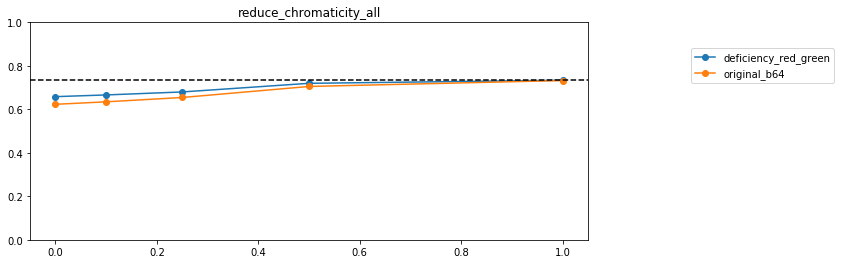

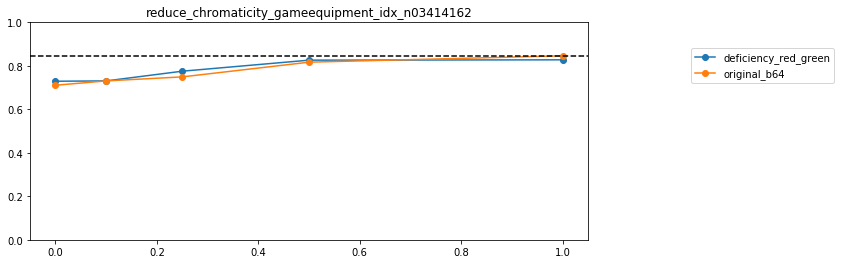

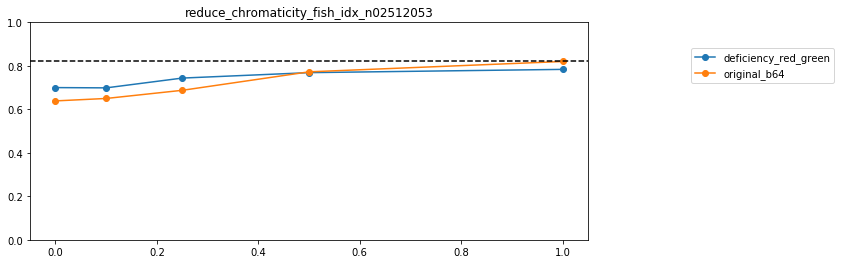

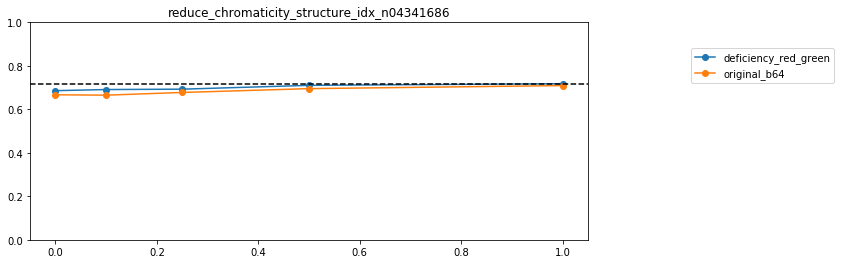

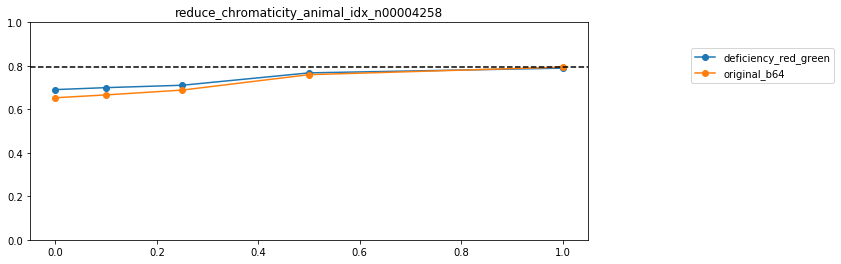

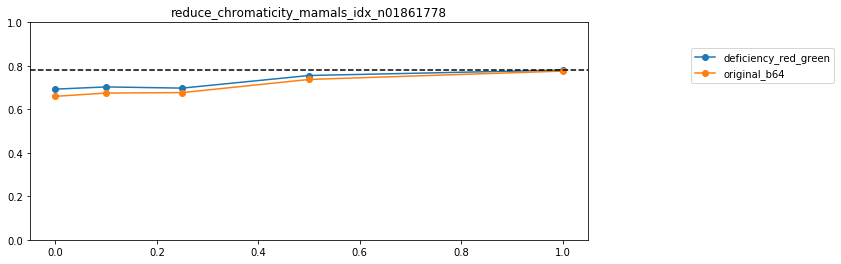

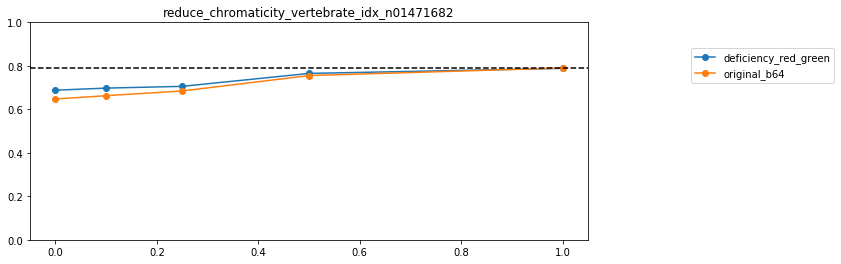

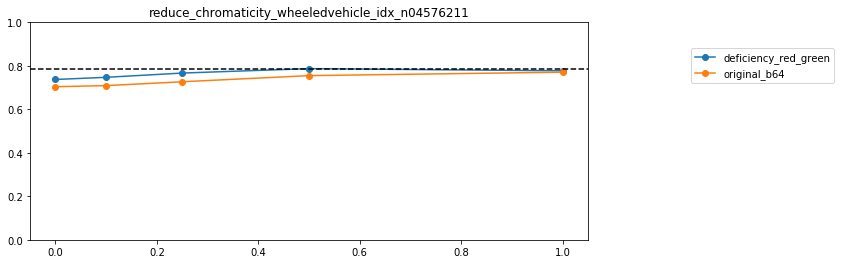

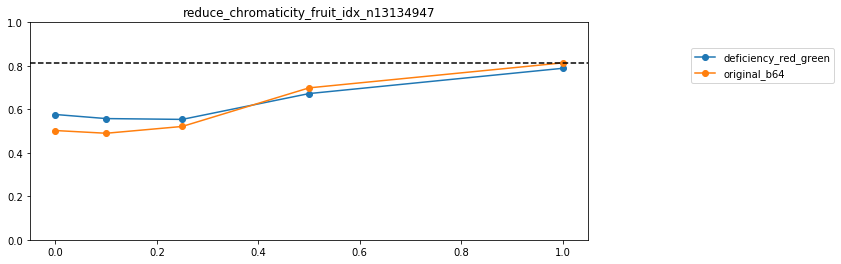

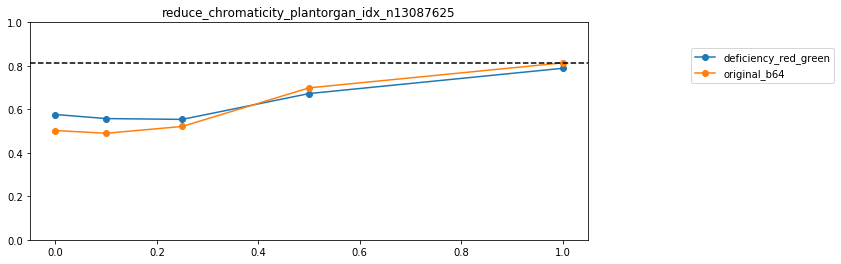

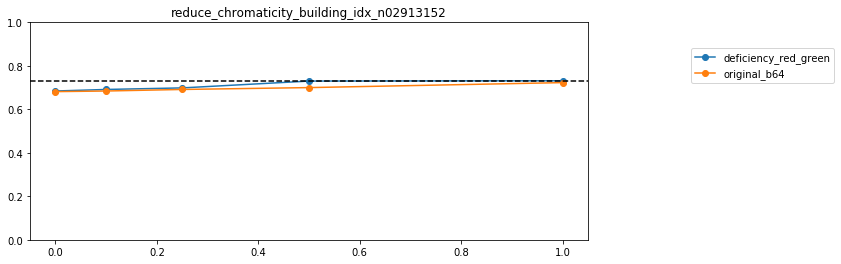

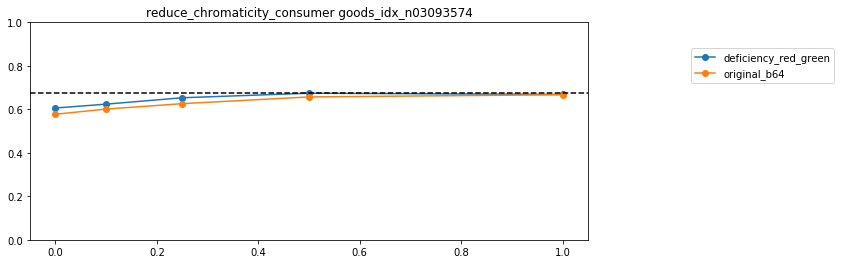

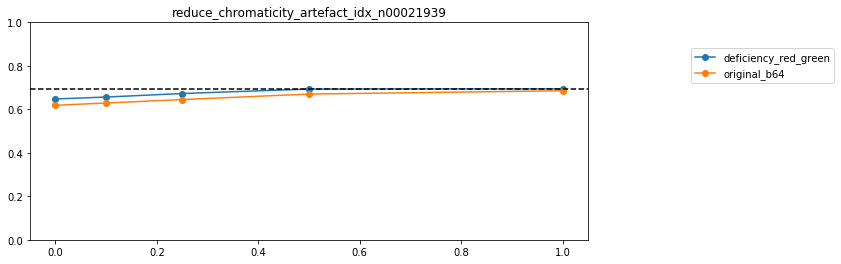

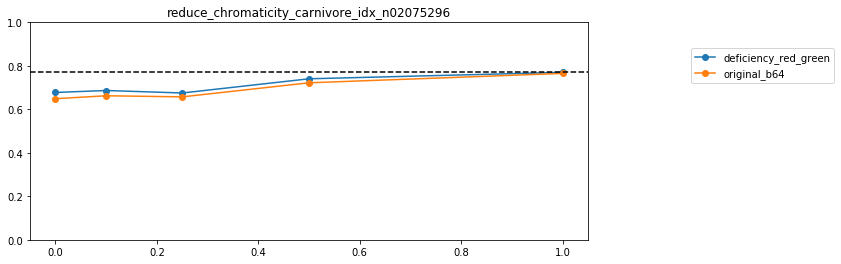

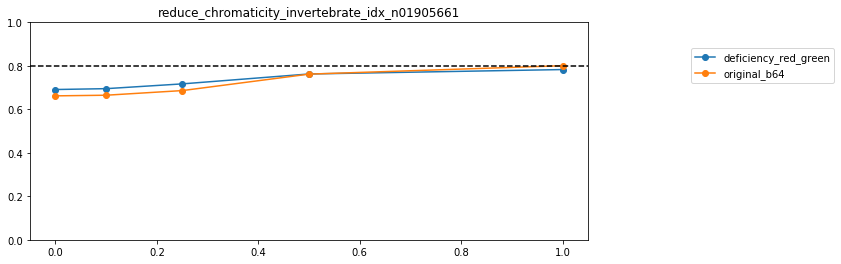

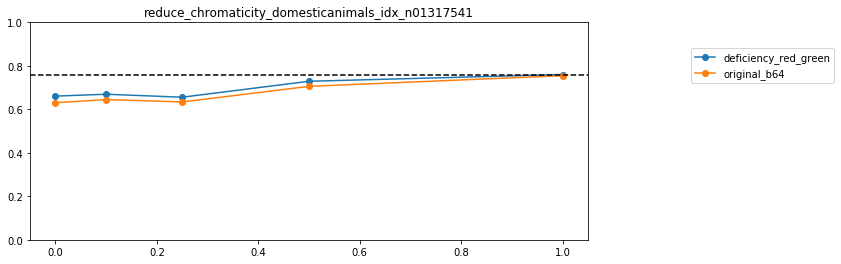

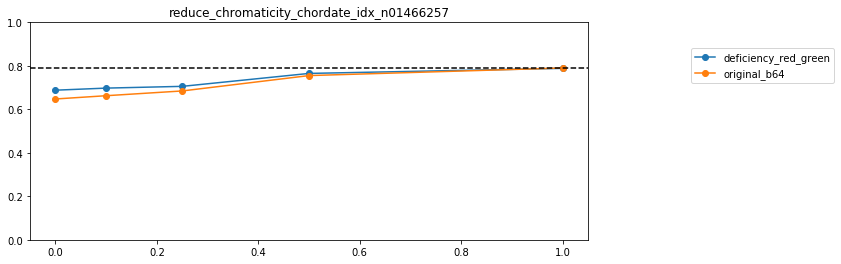

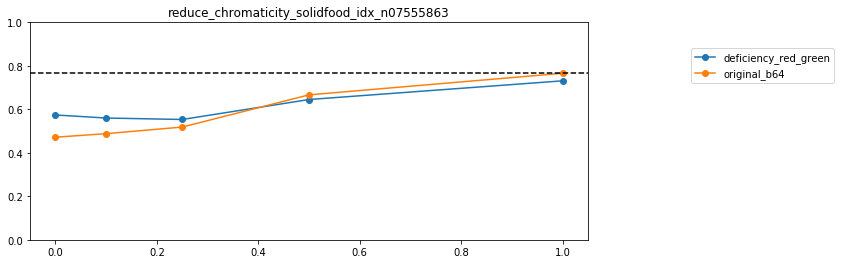

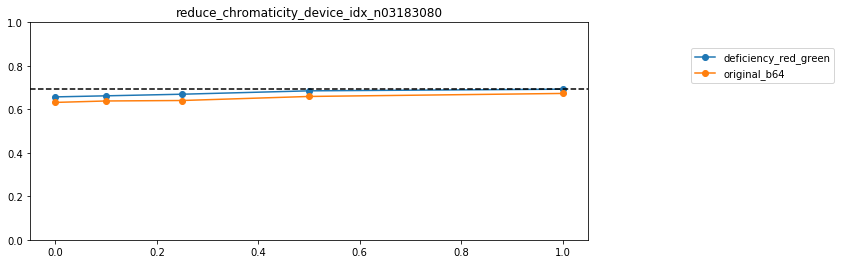

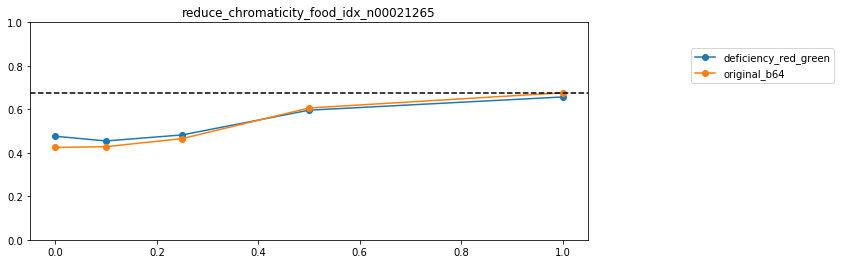

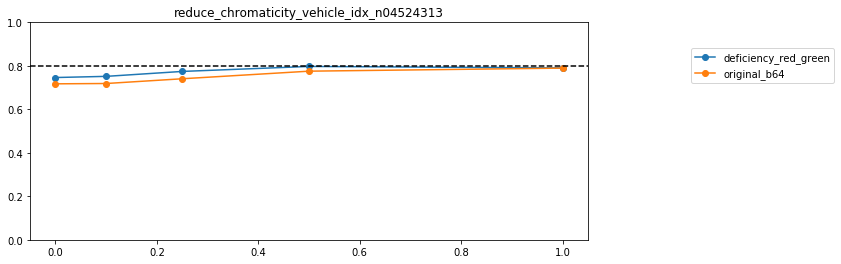

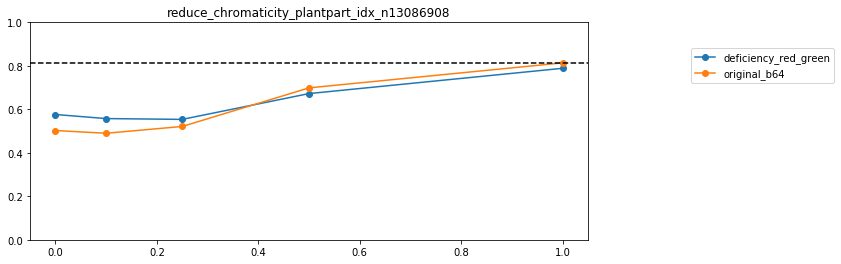

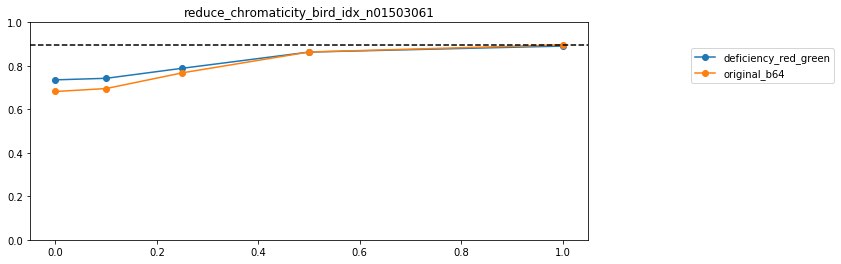

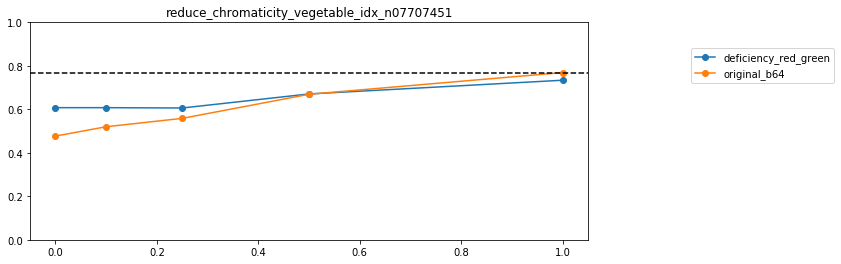

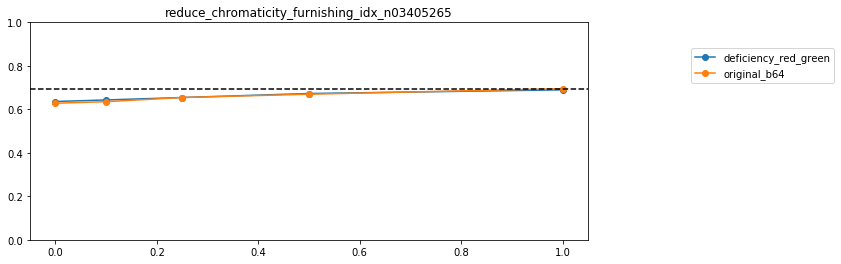

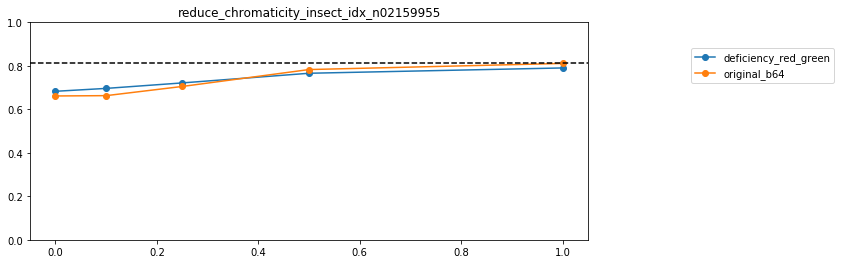

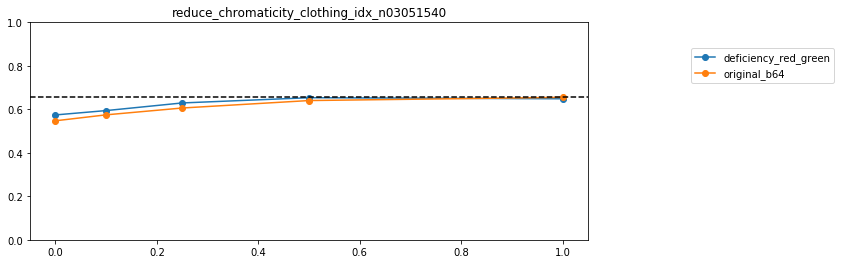

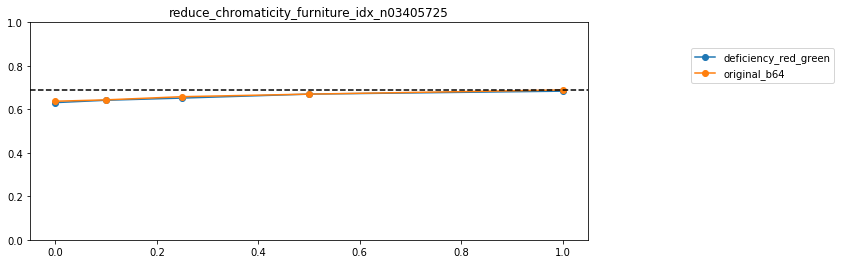

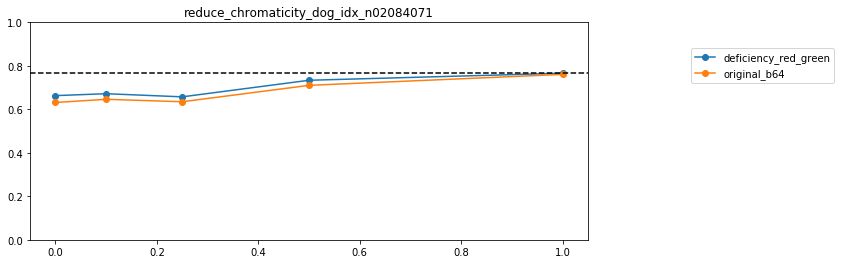

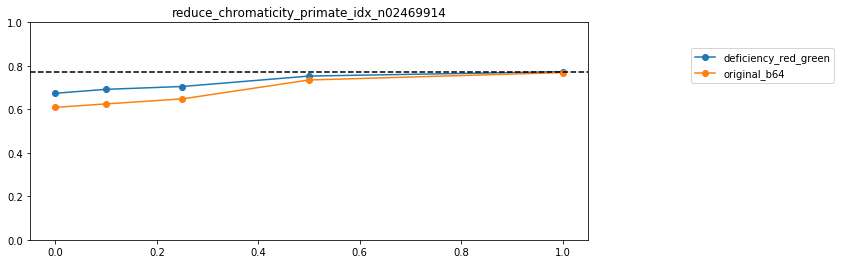

In [237]:
resnet_result = do_one_network(resnet_result_dir, which_experiments[5:6],
                               original_values[5:6], all_categories, ['deficiency_red_green', 'original_b64'])

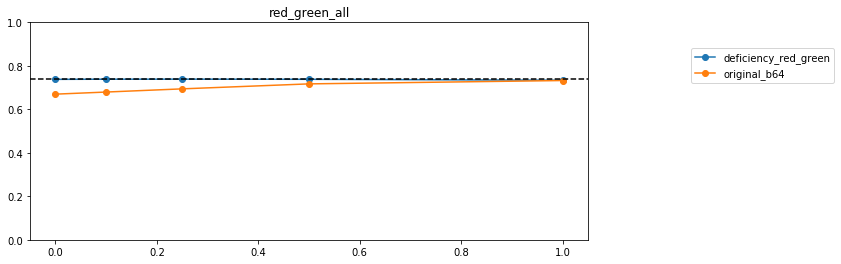

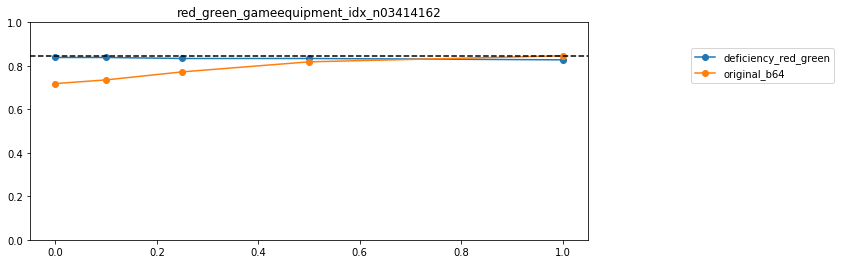

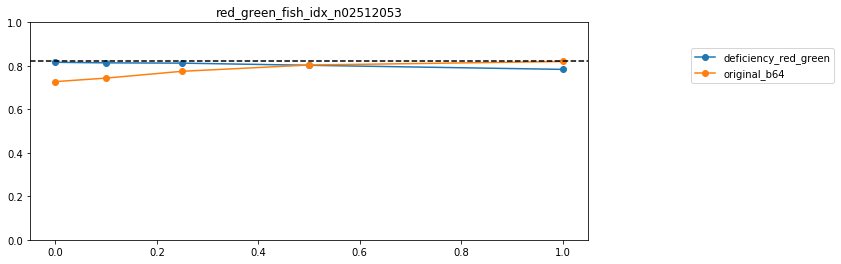

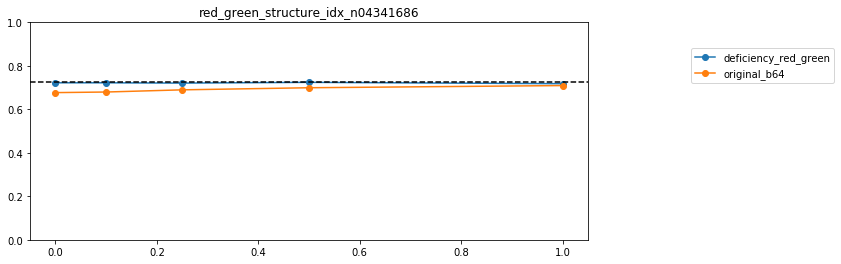

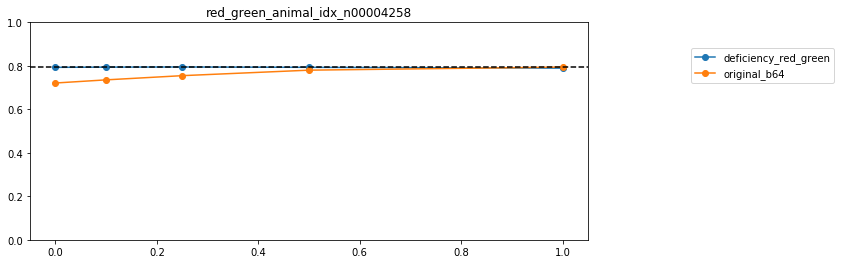

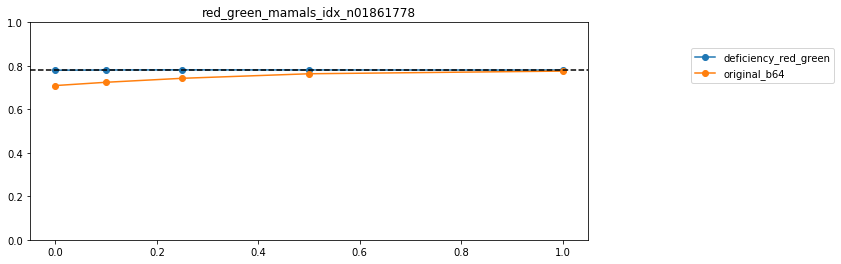

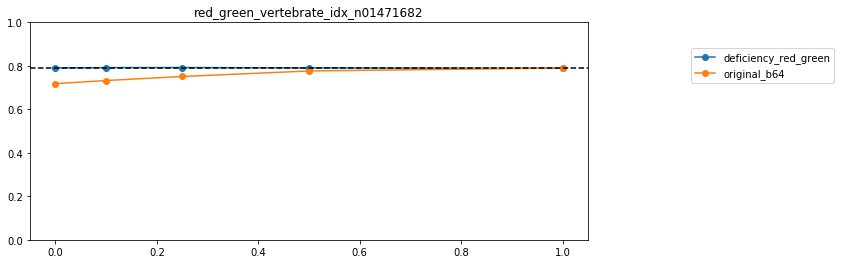

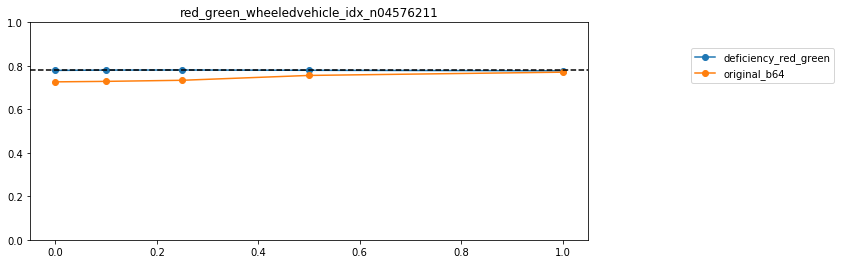

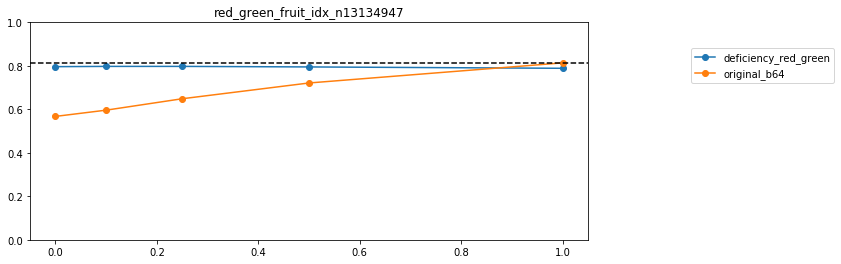

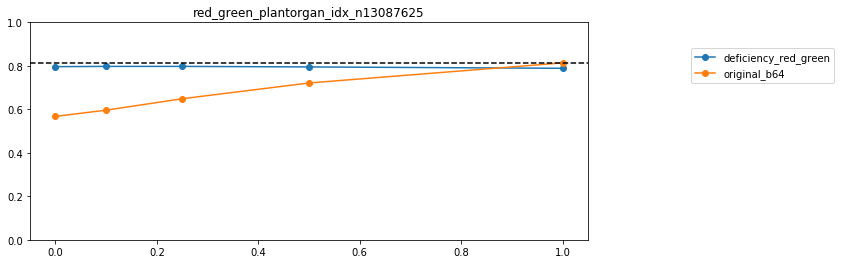

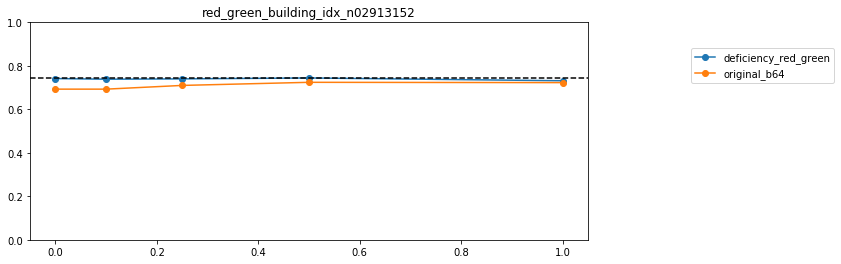

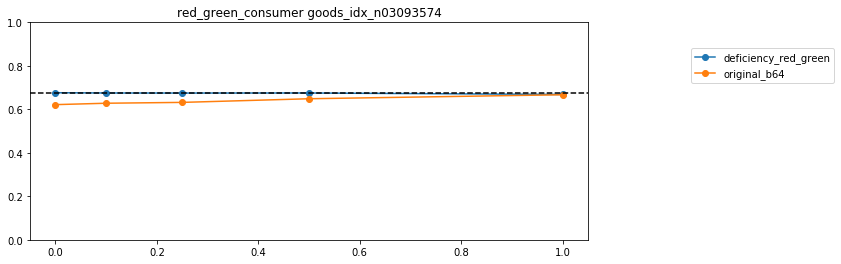

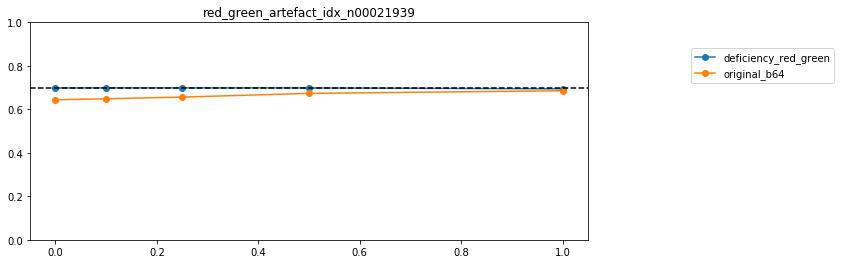

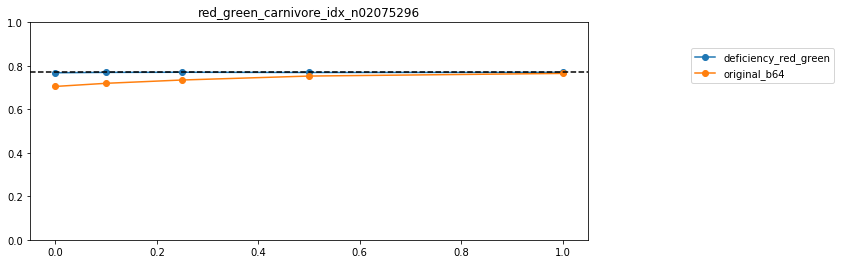

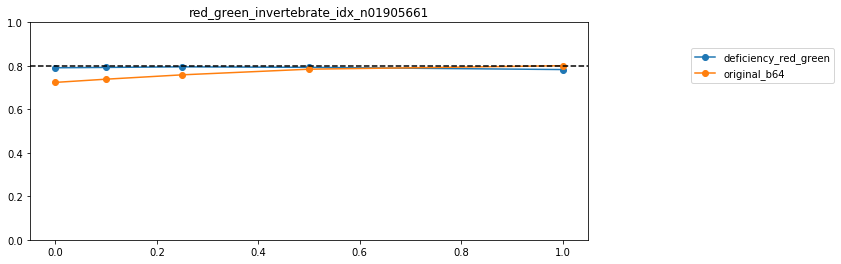

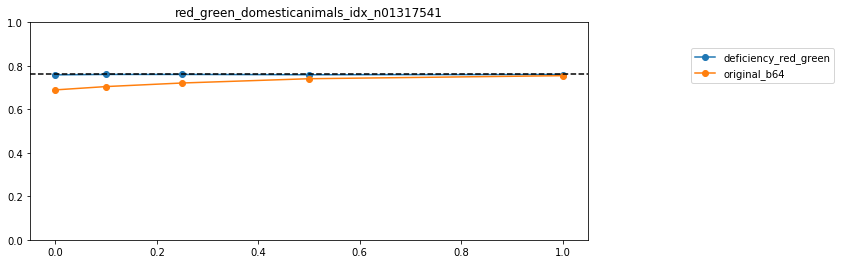

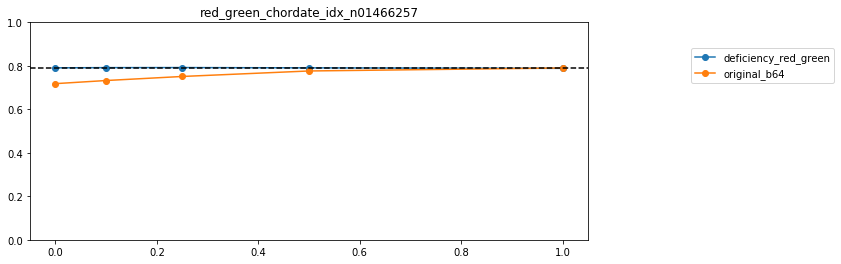

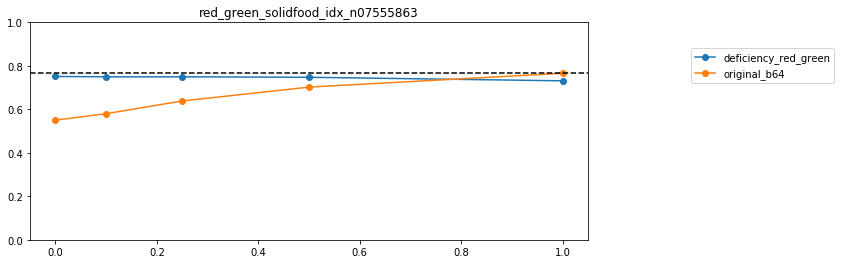

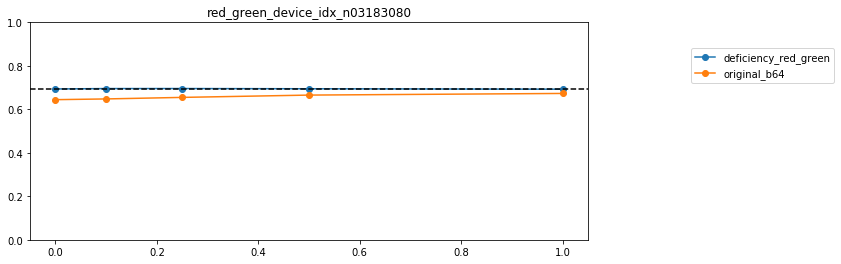

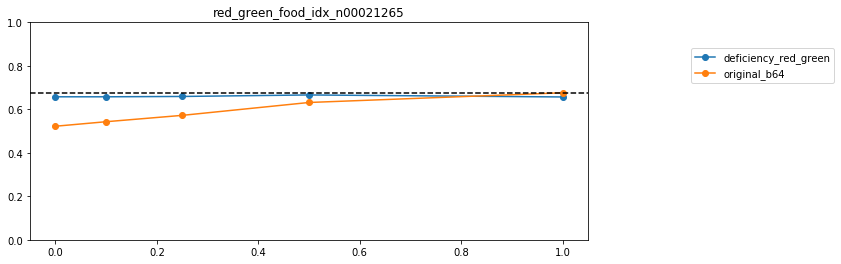

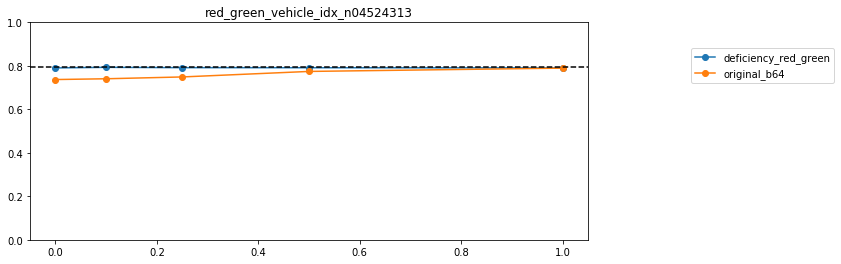

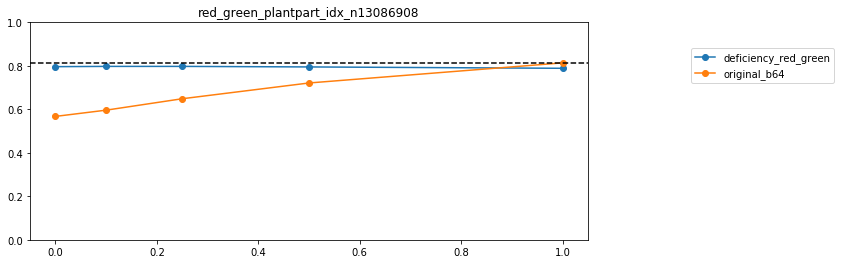

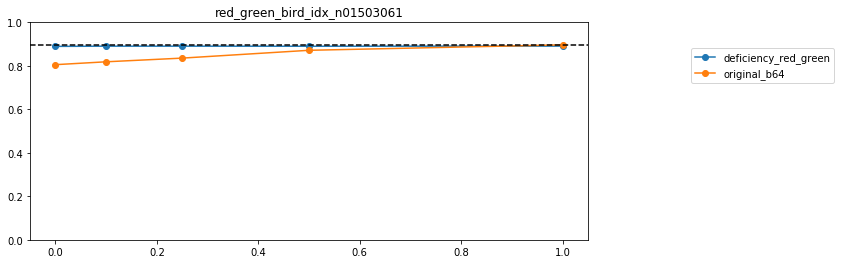

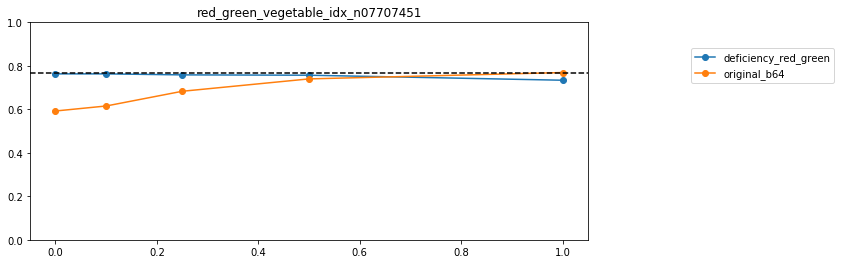

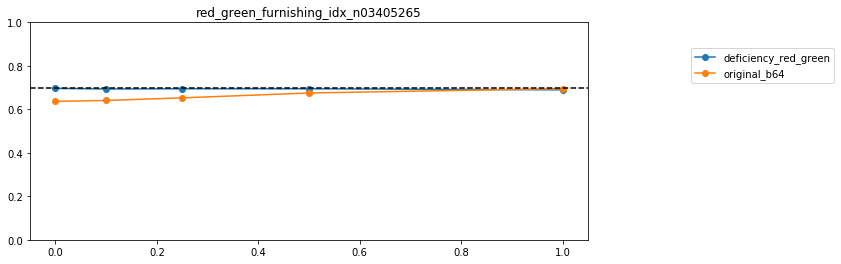

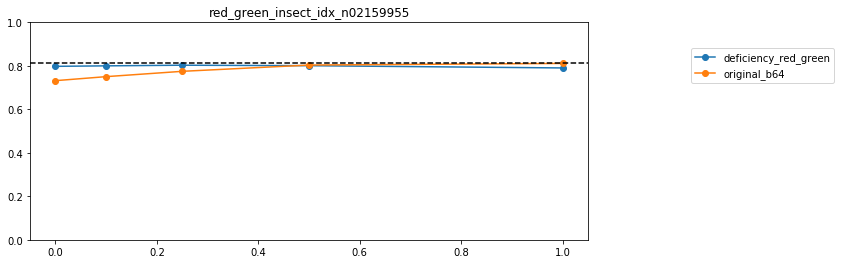

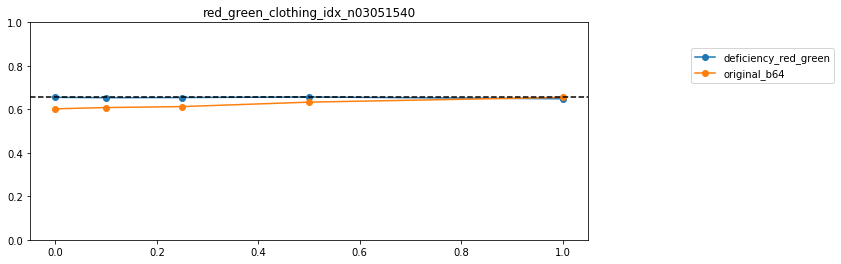

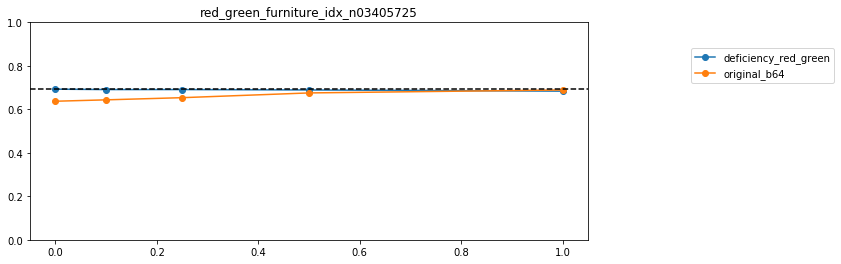

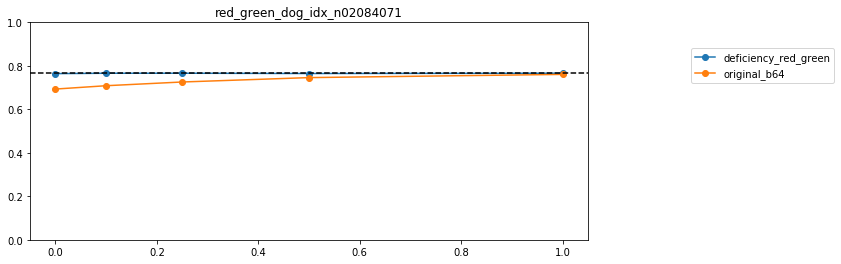

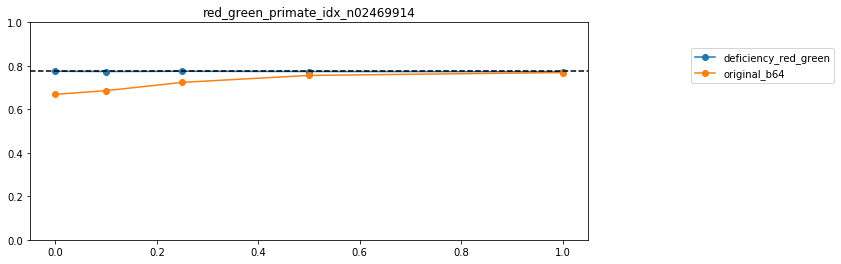

In [235]:
resnet_result = do_one_network(resnet_result_dir, which_experiments[6:7],
                               original_values[6:7], all_categories, ['deficiency_red_green', 'original_b64'])

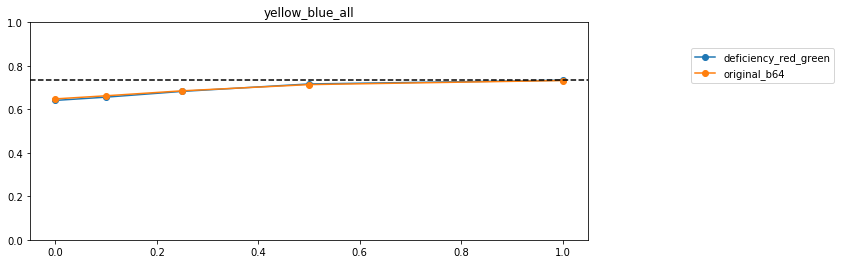

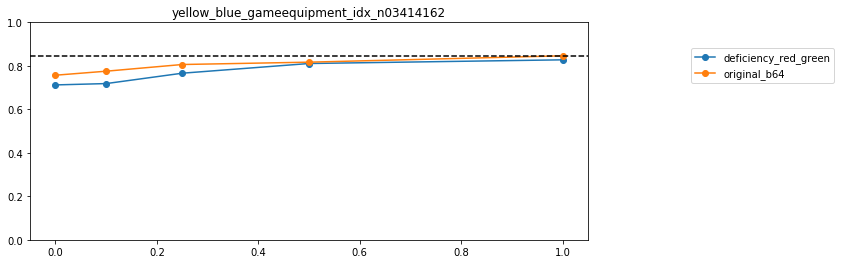

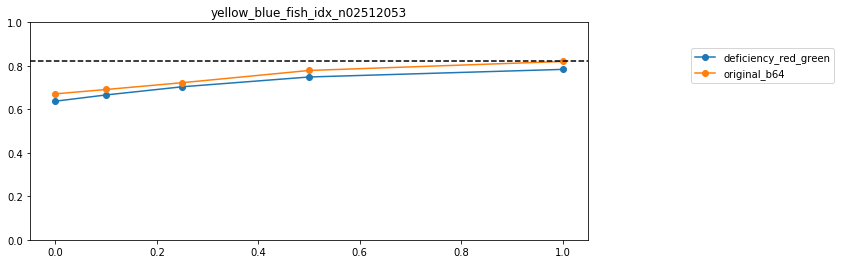

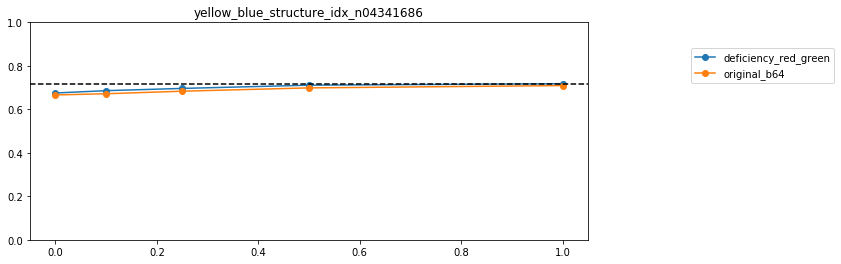

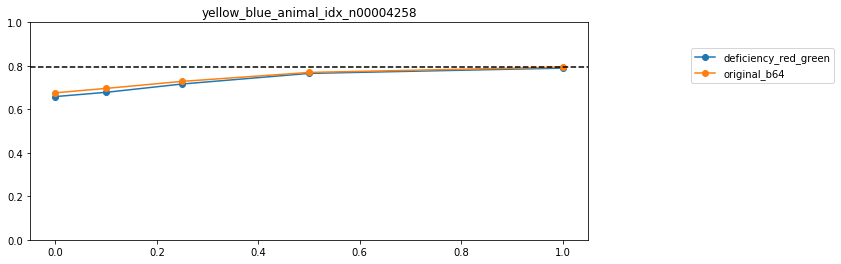

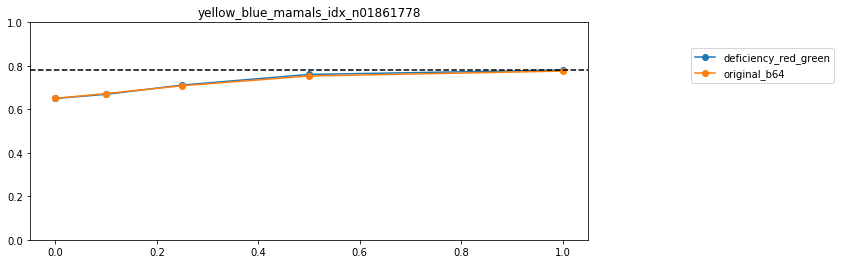

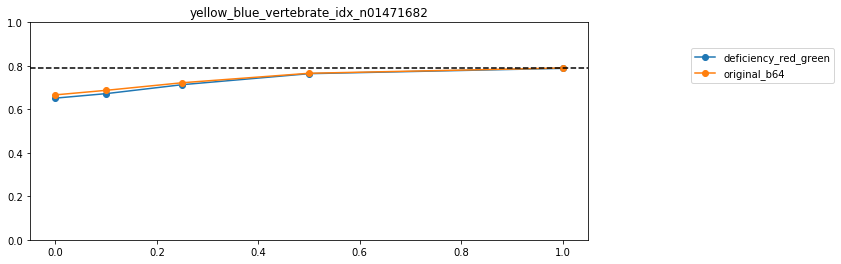

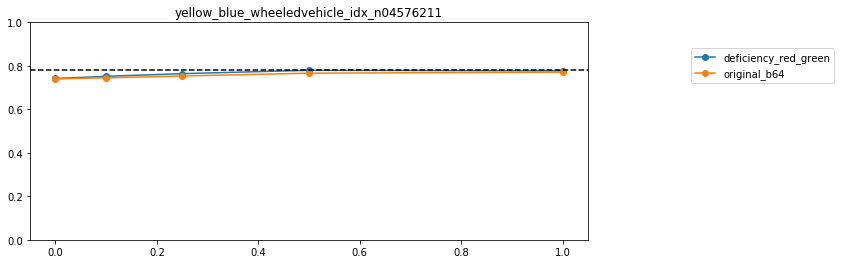

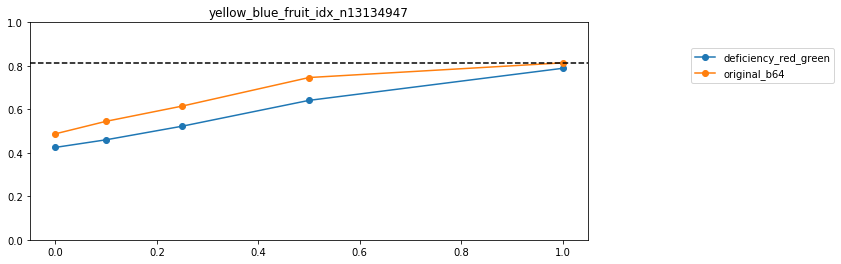

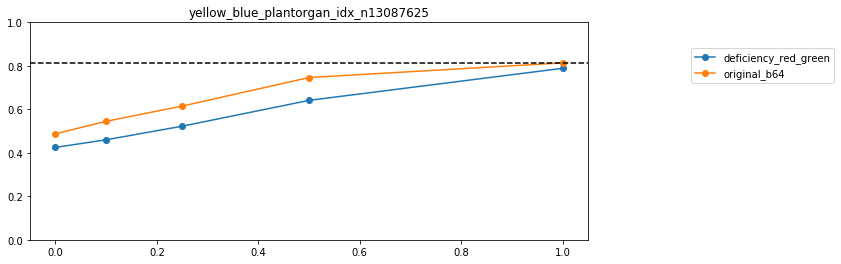

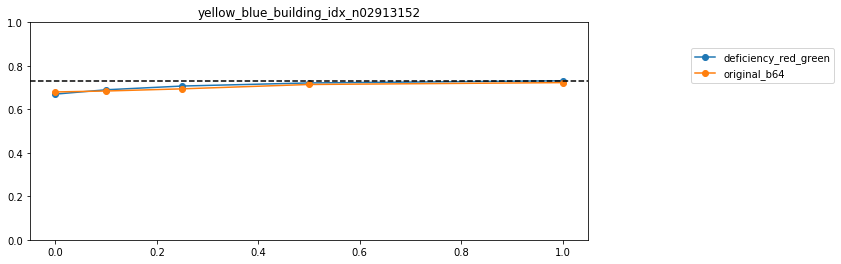

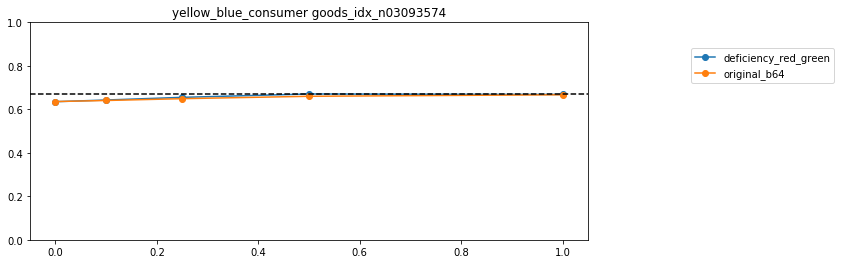

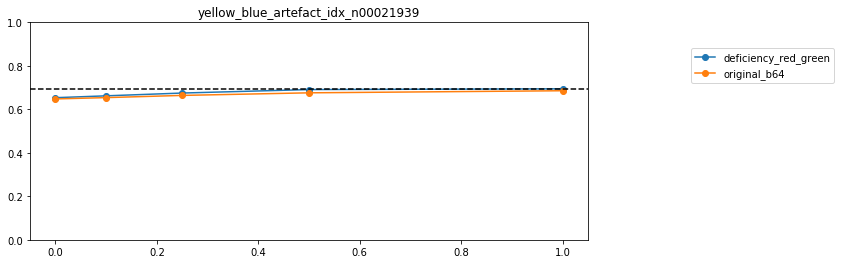

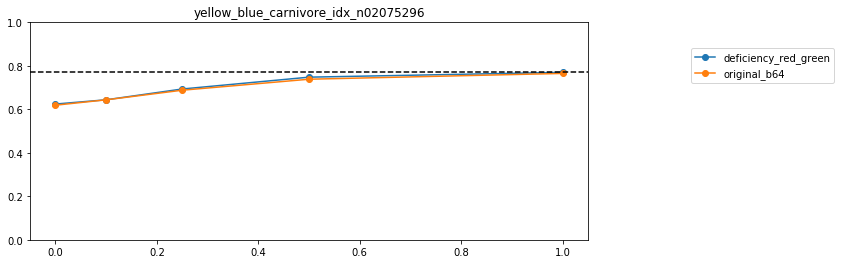

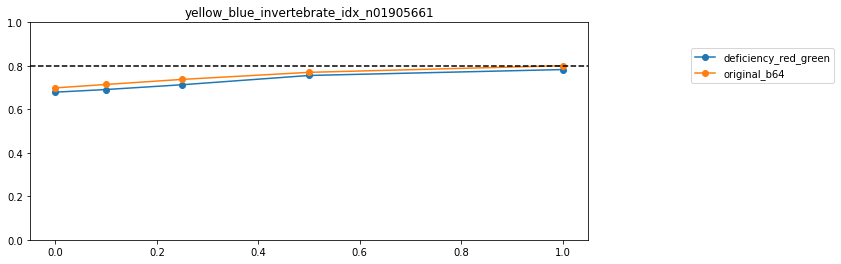

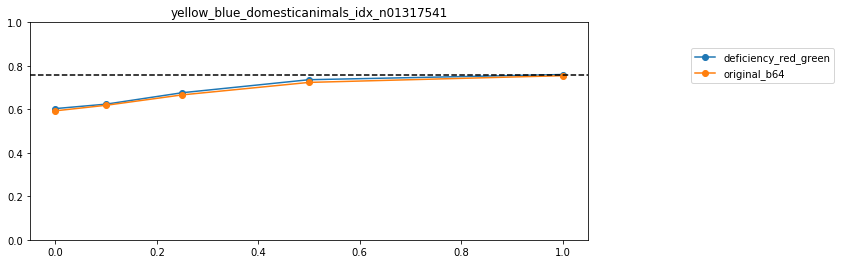

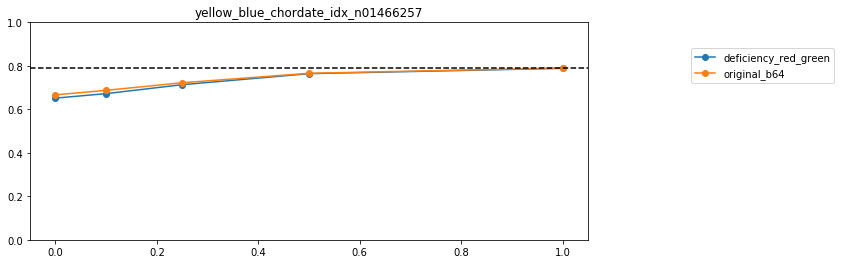

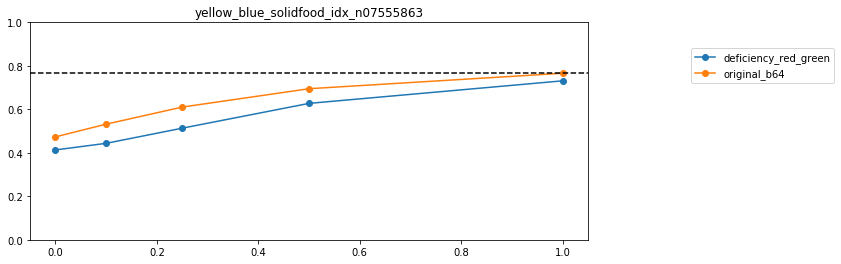

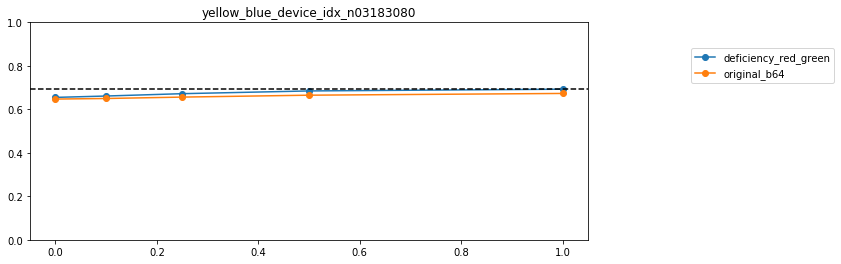

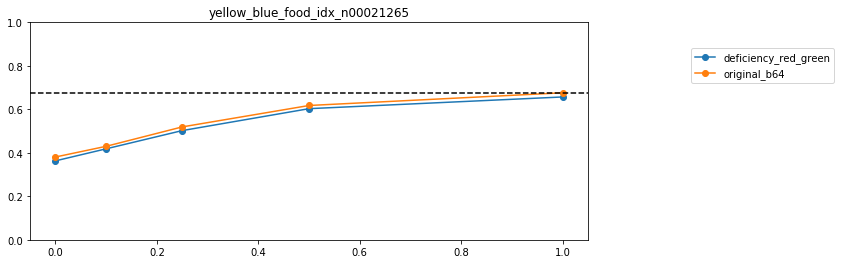

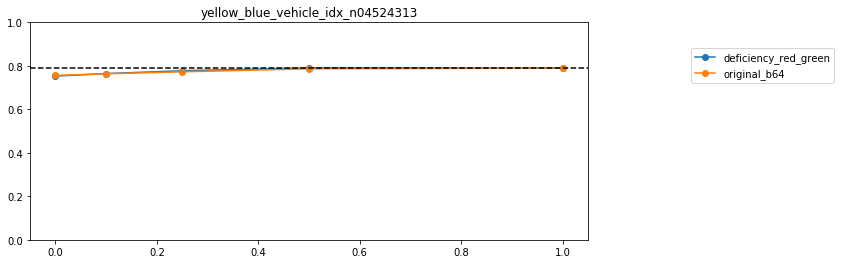

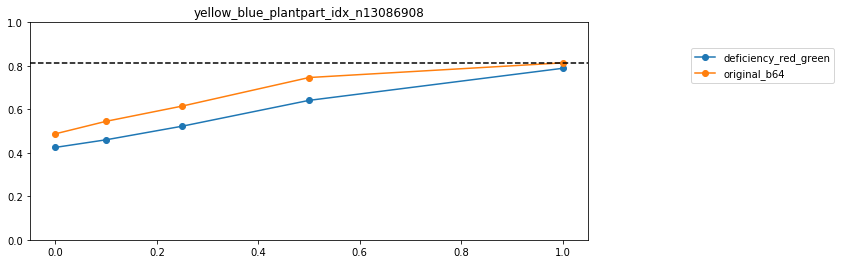

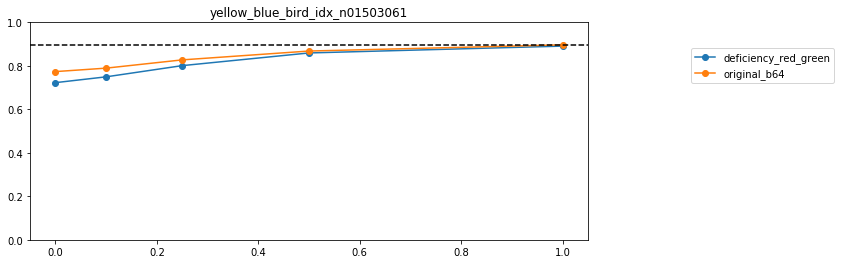

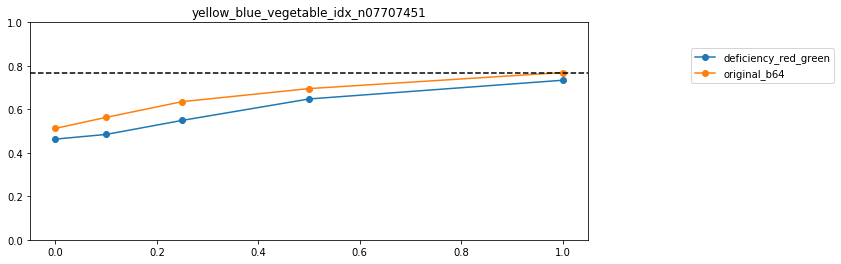

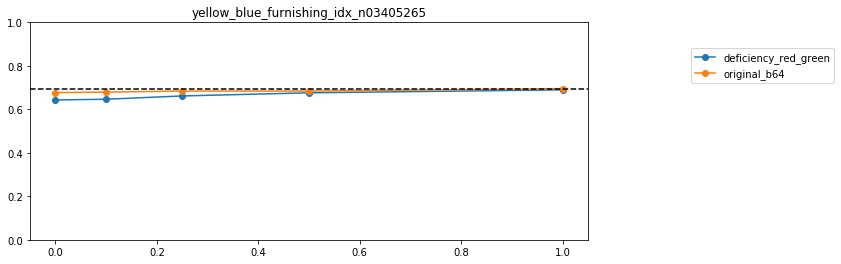

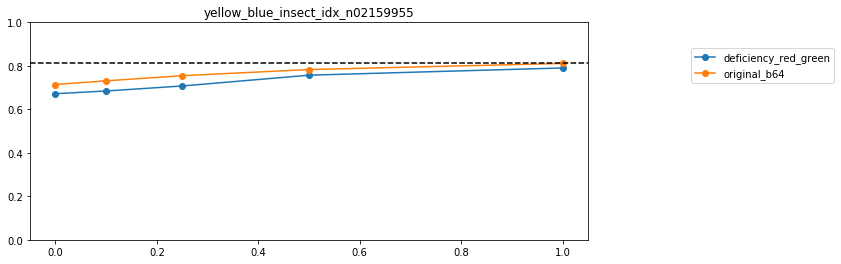

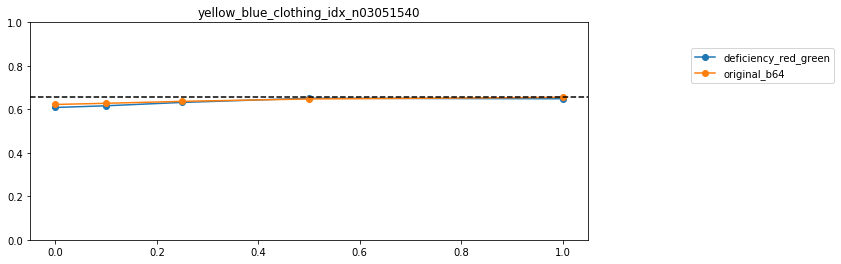

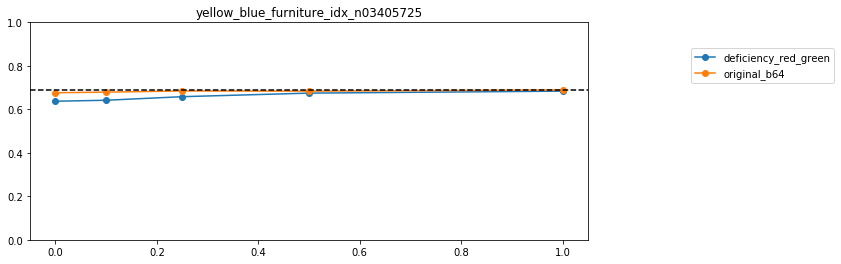

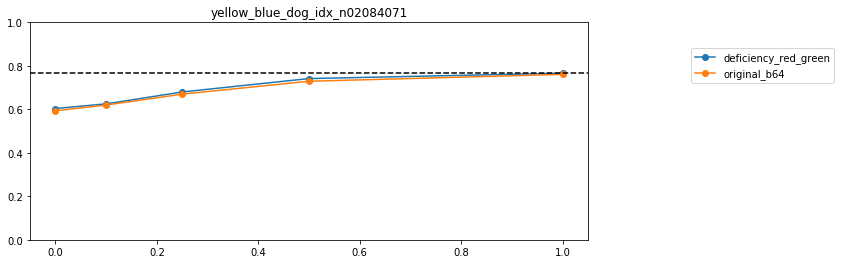

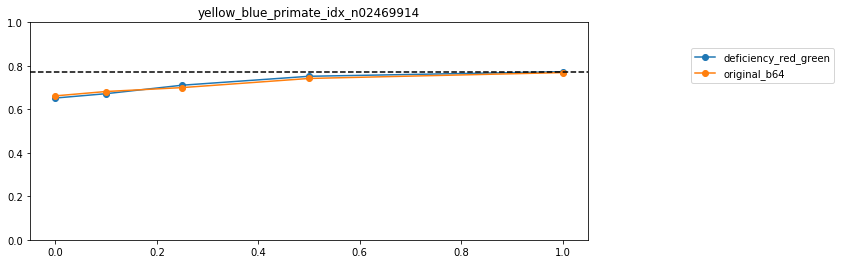

In [238]:
resnet_result = do_one_network(resnet_result_dir, which_experiments[7:8],
                               original_values[7:8], all_categories, ['deficiency_red_green', 'original_b64'])

In [159]:
which_experiments = ['gaussian_blurring', 'gaussian_noise', 'speckle_noise', 's_p_noise', 
                     'gammas', 'reduce_chromaticity','red_green', 'yellow_blue', 'reduce_lightness',
                    'contrast_reduction']
original_values = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]

resnet_result_dir = '/mnt/hdd/Dropbox/Jobs/Giessen/kernelphysiology/results/PytorchPredictionsWithLabel/ResNet50/'

inception_result_dir = '/mnt/hdd/Dropbox/Jobs/Giessen/kernelphysiology/results/PytorchPredictionsWithLabel/InceptionV3/'

densenet_result_dir = '/mnt/hdd/Dropbox/Jobs/Giessen/kernelphysiology/results/PytorchPredictionsWithLabel/DenseNet161/'

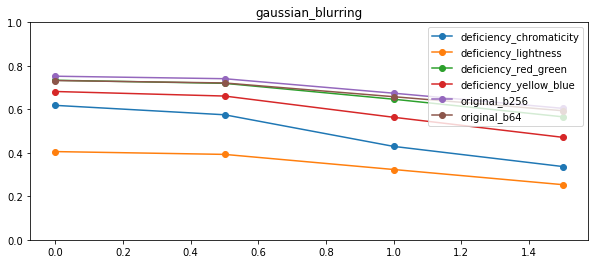

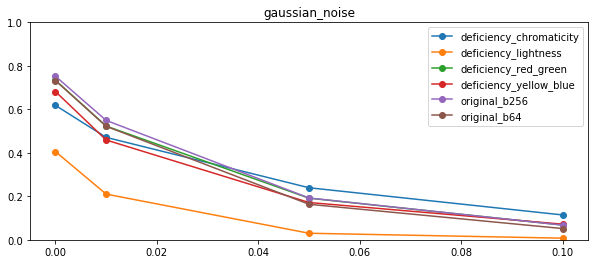

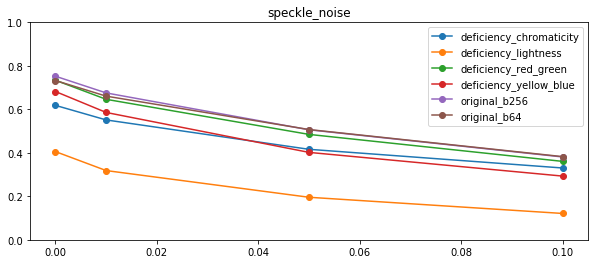

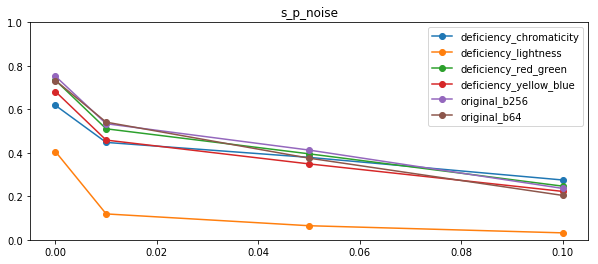

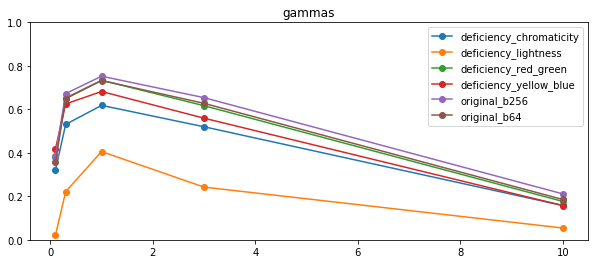

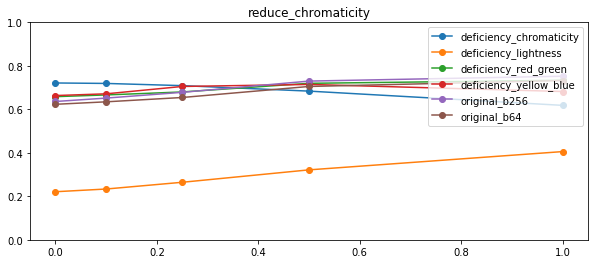

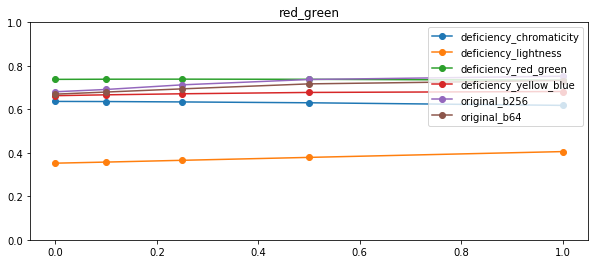

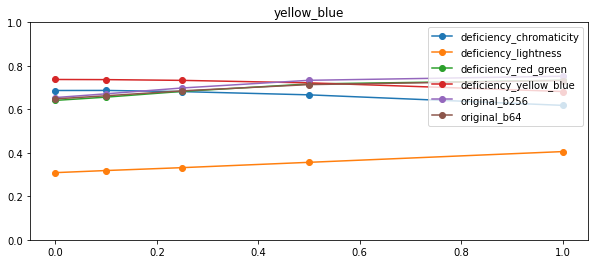

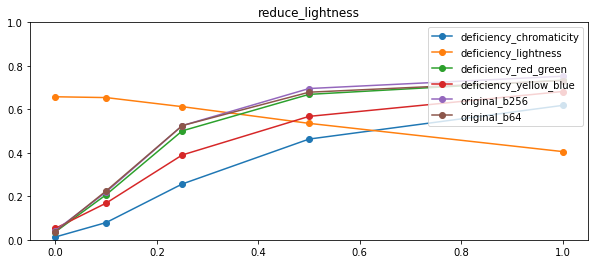

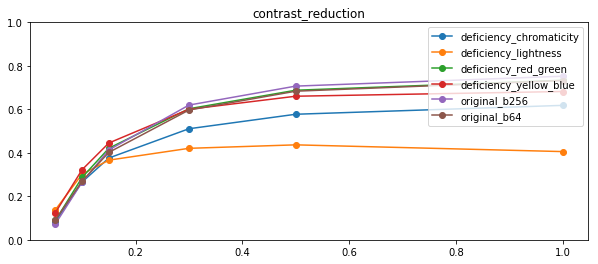

In [160]:
do_one_network(resnet_result_dir, which_experiments, original_values)

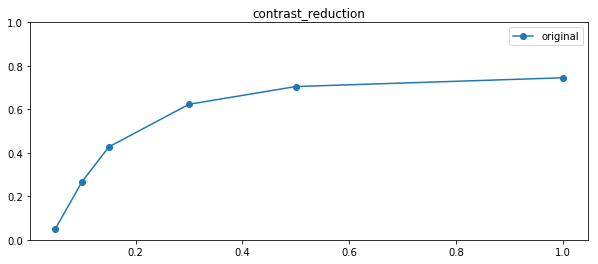

In [157]:
do_one_network(inception_result_dir, which_experiments, original_values)

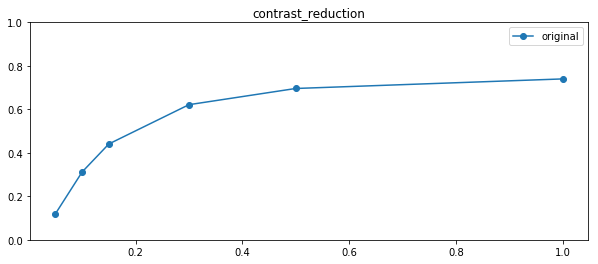

In [158]:
do_one_network(densenet_result_dir, which_experiments, original_values)